<a href="https://www.kaggle.com/code/hsw1212/catsvsdogs-resnet?scriptVersionId=140461126" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Set transform for image augmentation
# 1. 隨機旋轉
# 2. 水平翻轉
# 3. Resize
# 4. Center crop

train_transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

In [2]:
# Set dataset where data from folders
train_data = datasets.ImageFolder(
    root=("/kaggle/input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/train"),
    transform=train_transform
)

test_data = datasets.ImageFolder(
    root=("/kaggle/input/dogs-vs-cats-for-pytorch/cat_dog_data/Cat_Dog_data/test/"),
    transform=test_transform
)

# Show classes name
class_names = train_data.classes
print(f"class names: {class_names[0]}, {class_names[1]}")



class names: cat, dog


In [3]:
# Set data loaders of train and test
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
test_loader=DataLoader(test_data,batch_size=32)

# Length of data
print(f"Length of train data: {len(train_data)}, Length of test data: {len(test_data)}")


Length of train data: 22500, Length of test data: 2500


labels: [1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1]
class:  dog dog dog cat cat dog cat dog dog cat dog dog dog dog dog cat cat dog cat cat cat dog dog cat dog dog cat dog dog cat cat dog


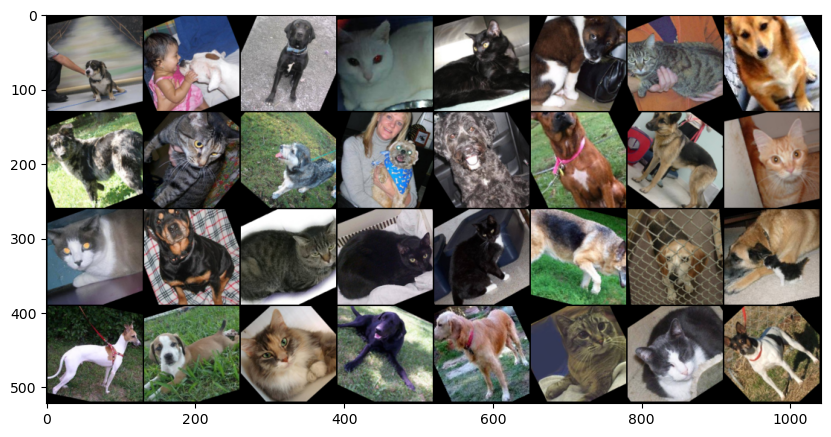

In [4]:
import numpy as np
from torchvision.utils import make_grid

# Show labels and images
for images, labels in train_loader:
    break

print(f"labels: {labels.numpy()}")
print("class: ", *np.array([class_names[i] for i in labels]))

import matplotlib.pyplot as plt

im = make_grid(images,nrow=8)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))



In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet34().to(device)
model.fc = nn.Sequential(
    nn.Linear(512,2,bias=True),
    nn.Softmax(dim=1)
    ).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)



In [6]:
# Train loop
num_epoch = 15
best_val_accuracy = 0.0

for epoch in range(num_epoch):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # _, labels = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f'Epoch [{epoch+1}/{num_epoch}], Validation Accuracy: {val_accuracy:.4f}, BEST Accuracy: {best_val_accuracy:.4f}')

print('Training Finished!')

Epoch [1/15], Validation Accuracy: 0.6296, BEST Accuracy: 0.6296
Epoch [2/15], Validation Accuracy: 0.6240, BEST Accuracy: 0.6296
Epoch [3/15], Validation Accuracy: 0.7248, BEST Accuracy: 0.7248
Epoch [4/15], Validation Accuracy: 0.7756, BEST Accuracy: 0.7756
Epoch [5/15], Validation Accuracy: 0.5324, BEST Accuracy: 0.7756
Epoch [6/15], Validation Accuracy: 0.8256, BEST Accuracy: 0.8256
Epoch [7/15], Validation Accuracy: 0.8368, BEST Accuracy: 0.8368
Epoch [8/15], Validation Accuracy: 0.8240, BEST Accuracy: 0.8368
Epoch [9/15], Validation Accuracy: 0.8240, BEST Accuracy: 0.8368
Epoch [10/15], Validation Accuracy: 0.8628, BEST Accuracy: 0.8628
Epoch [11/15], Validation Accuracy: 0.8684, BEST Accuracy: 0.8684
Epoch [12/15], Validation Accuracy: 0.8536, BEST Accuracy: 0.8684
Epoch [13/15], Validation Accuracy: 0.7884, BEST Accuracy: 0.8684
Epoch [14/15], Validation Accuracy: 0.8740, BEST Accuracy: 0.8740
Epoch [15/15], Validation Accuracy: 0.8820, BEST Accuracy: 0.8820
Training Finished!


Predicted value: 1 dog


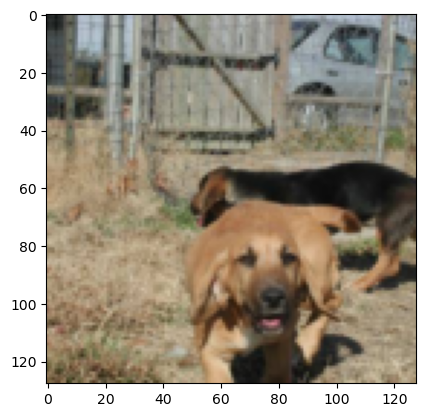

In [7]:
model = models.resnet34().to(device)
model.fc = nn.Sequential(
    nn.Linear(512,2,bias=True),
    nn.Softmax(dim=1)
    ).to(device)

model.load_state_dict(torch.load('best_model.pth'))

x=2021
im = test_data[x][0]
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#Evaluating our CNN model 
model.eval()
with torch.no_grad():
    new_pred=model(test_data[x][0].view(1,3,128,128).to(device)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')